# CECS 456 Deep Learning Project

## Imports

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
import random


## Define constants

In [14]:

imgSize = 128
batchSize = 32
animalsCnt = 10
epochs = 10
datasetPath = "archive/raw-img" # Path to images

#Translation
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}


## Data preparation & load dataset

In [15]:

# Data augmentation
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.15,
    horizontal_flip = True,
    zoom_range = 0.2,
)

# Load training data
train_data = datagen.flow_from_directory(
    datasetPath,
    target_size = (imgSize, imgSize),
    batch_size = batchSize,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

# Load validation data
val_data = datagen.flow_from_directory(
    datasetPath,
    target_size = (imgSize, imgSize),
    batch_size = batchSize,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True
)

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


# Visualize dataset distribution across classes

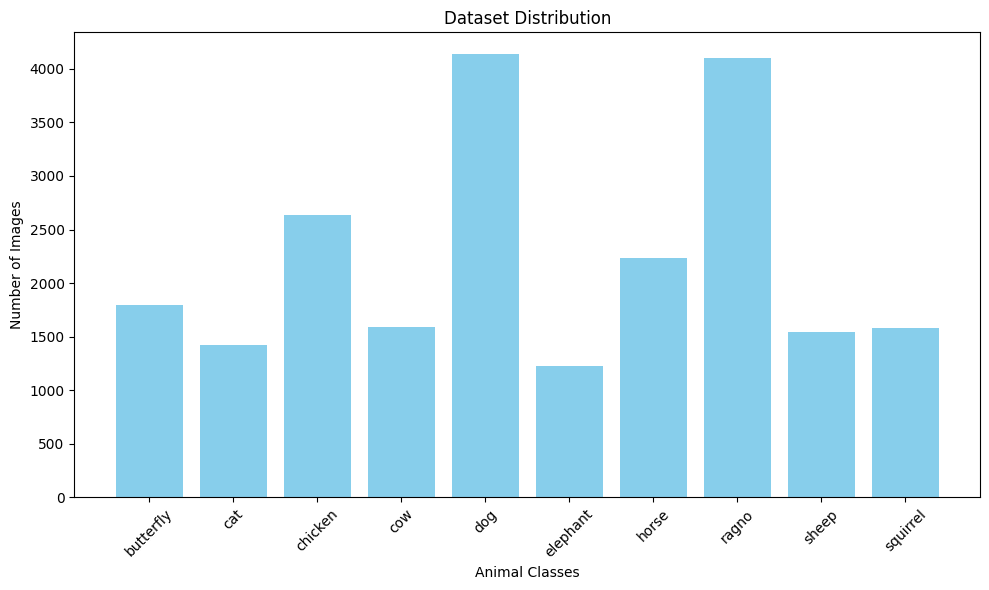

In [16]:

# Display image distribution across dataset
classes = train_data.class_indices
class_counts = Counter(train_data.classes)

plt.figure(figsize=(10, 6))
plt.bar(classes.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Animal Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


## Examples from dataset

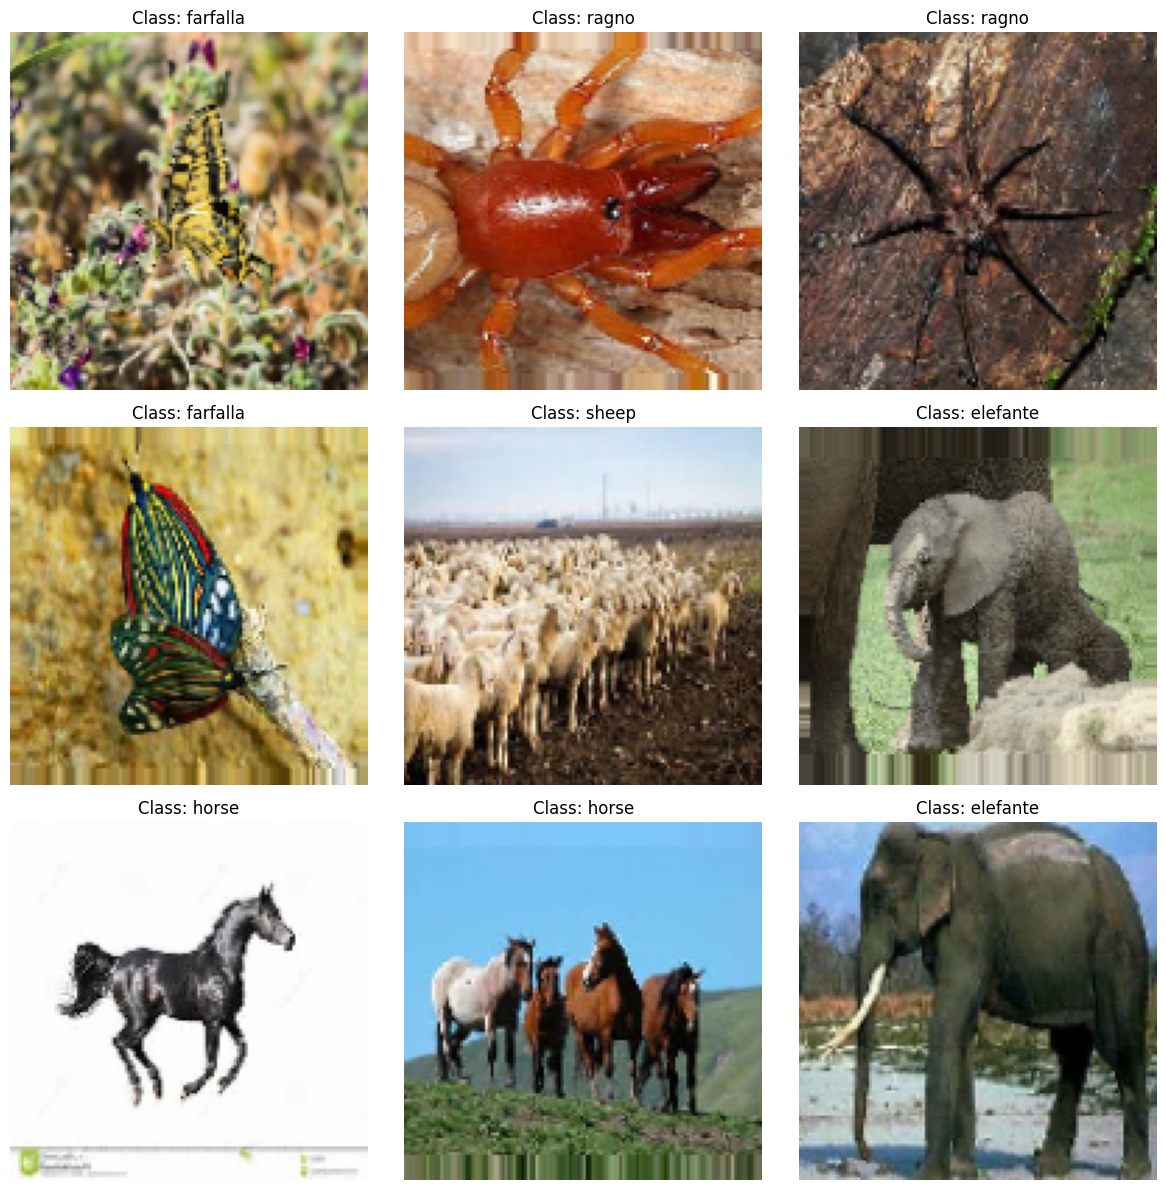

In [17]:
# Display images from the dataset with class labels
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_data):
    if i >= 9:
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    translatedLabel = [k for k, v in classes.items() if v == np.argmax(label[0])][0]
    plt.title(f"Class: {translate.get(translatedLabel, translatedLabel)}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Define, build, and compile the model for training

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Define VGG Model 
vggModel = VGG16(weights = 'imagenet', include_top = False, input_shape = (imgSize, imgSize, 3))
for layer in vggModel.layers[:-4]: # Freeze layers from vggModel
    layer.trainable = False


model = Sequential([
    vggModel,
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dropout(0.5),
    Dense(animalsCnt, activation = 'softmax')
])

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 7,213,322 (27.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3) # EarlyStopping after validation checks


history = model.fit(train_data, epochs = epochs, validation_data = val_data, callbacks = [earlyStopping]) # Training the model


C:\Users\steve\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 72/696 ━━━━━━━━━━━━━━━━━━━━ 6:56 667ms/step - accuracy: 0.2819 - loss: 2.0711

KeyboardInterrupt: 

## Evaluate accuracy and total loss on training data

In [ ]:

total_loss, total_accuracy = model.evaluate(train_data) # Evaluation of accuracy and loss
print("Accuracy on Training Set: ", total_accuracy)
print("Total loss on Training Set: ", total_loss)

 46/696 ━━━━━━━━━━━━━━━━━━━━ 6:13 575ms/step - accuracy: 0.3811 - loss: 1.9036

KeyboardInterrupt: 

## Plot training and validation accuracy/loss

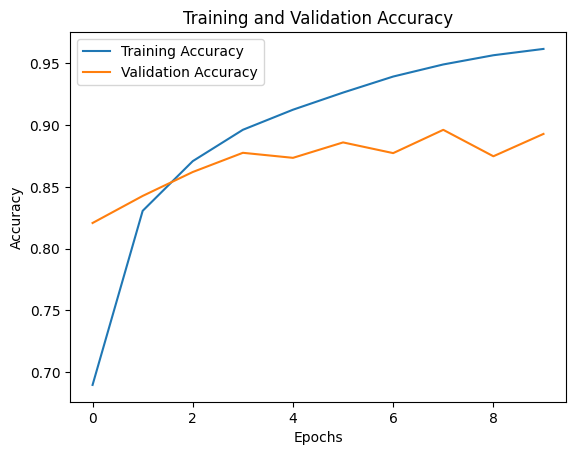

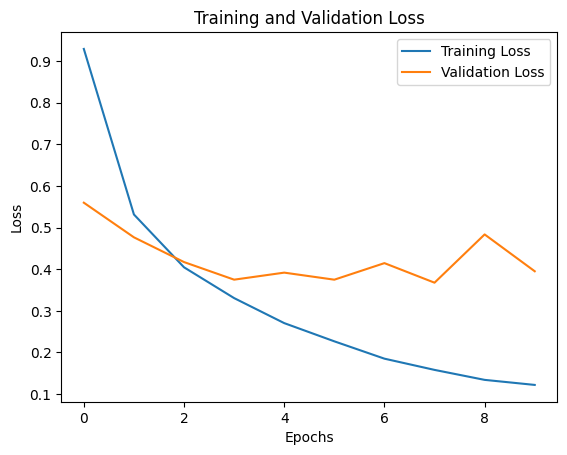

In [25]:
#Training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

#Training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


## Predictions on validation images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


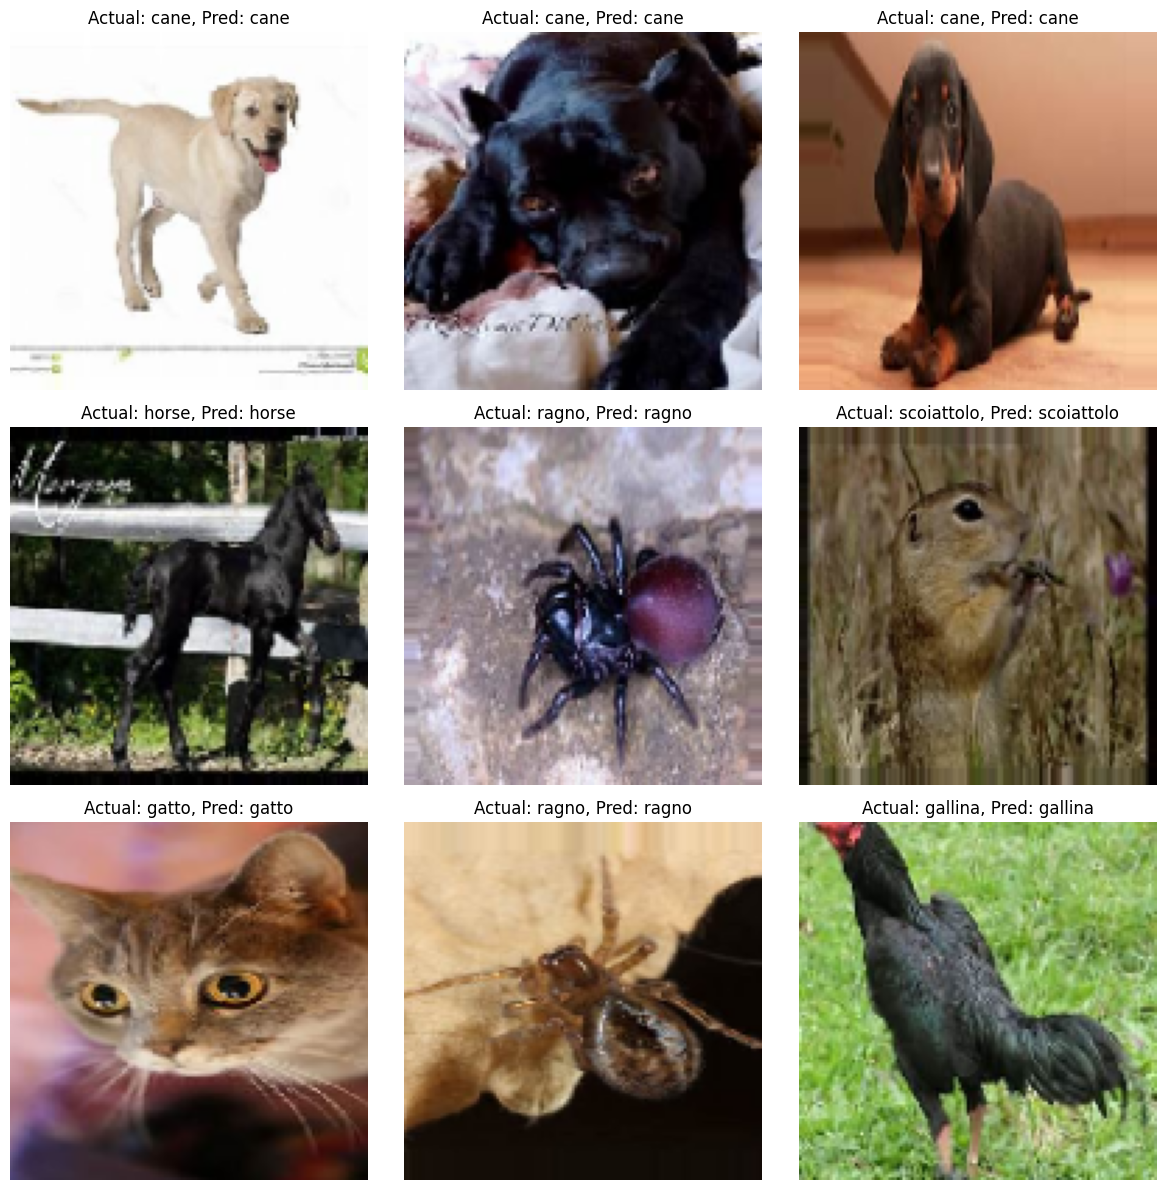

In [26]:

plt.figure(figsize=(12, 12)) # set size of figure
for i, (image, label) in enumerate(val_data):
    if i >= 9:
        break
    pred = model.predict(image) # get prediction
    predicted_class = [k for k, v in classes.items() if v == np.argmax(pred[0])][0] # get predicted classes
    actual_class = [k for k, v in classes.items() if v == np.argmax(label[0])][0] # get actual classes
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(f"Actual: {translate.get(actual_class, actual_class)}, Pred: {translate.get(predicted_class, predicted_class)}")
    plt.axis('off')
plt.tight_layout()
plt.show()